In [12]:
import numpy as np
import pandas as pd
import EEG_Decoder.eeg_decoder as eeg_decoder
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['svg.fonttype'] = 'none' # change svg font type from path to text

import seaborn as sns
from collections import defaultdict 

from utils import clean_behavior, setup_hyperplane_conds

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

from collections import OrderedDict, defaultdict

import os

from sklearn.covariance import LedoitWolf
from rsatoolbox.rdm.calc import _calc_rdm_crossnobis_single
from scipy.spatial.distance import squareform
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from mne.parallel import parallel_func

from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
overwrite_RDMs = False  # set to True to recompute and overwrite saved RDMs

np.random.seed(2023)

In [5]:
experiment_name = 'DATA/Preprocessed'
data_dir = f'../../{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
exp.behavior_files = sorted(list(exp.data_dir.glob('*.csv')))

In [6]:
full_times = np.arange(-650, 1650, 2)
tois = np.arange(-250, 1250, 2)
times_bool = [1 if (t in tois) else 0 for t in full_times]

In [7]:
time_window = 25
time_step = 25
trial_bin_size = 15
n_splits = 2  # unused, arbitrary
group_dict = OrderedDict([('1',[1]),('2',[2]),('3',[3]),('4',[4]),('5',[5]),('6',[6]),('7',[7]),('8',[8])])

wrangl = eeg_decoder.Wrangler(tois,time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [8]:
color_palette = {
 'Set Size': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Number of Locations': (1.0, 0.4980392156862745, 0.054901960784313725),
 'Overlap Process': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'Attended Area': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 'Total': (0, 0., 0)}

## Set up RDMs

In [9]:
condition_breakdown = {
    'SS1 Narrow': {'Set Size': 1, 'Number of Locations': 1, 'Overlap Process': False, 'Attended Area': 1},
    'SS1 Broad': {'Set Size': 1, 'Number of Locations': 1, 'Overlap Process': False, 'Attended Area': 3},
    'SS2 Overlap Narrow': {'Set Size': 2, 'Number of Locations': 1, 'Overlap Process': True, 'Attended Area': 1},
    'SS2 Overlap Broad': {'Set Size': 2, 'Number of Locations': 1, 'Overlap Process': True, 'Attended Area': 3},
    'SS2 Overlap Superset': {'Set Size': 2, 'Number of Locations': 1, 'Overlap Process': True, 'Attended Area': 3},
    'SS2 Overlap Partial': {'Set Size': 2, 'Number of Locations': 1, 'Overlap Process': True, 'Attended Area': 4.5},
    'SS2 NoOverlap Mixed': {'Set Size': 2, 'Number of Locations': 7/5, 'Overlap Process': False, 'Attended Area': 4,},  # 2/5 separate (2), 3/5 contiguous (1)
    'SS2 NoOverlap Narrow': {'Set Size': 2, 'Number of Locations': 12/7, 'Overlap Process': False, 'Attended Area': 2},  # 5/7 separate (2), 2/7 contiguous (1)
    'SS2 NoOverlap Broad': {'Set Size': 2, 'Number of Locations': 4/3, 'Overlap Process': False, 'Attended Area': 6},  # 1/3 separate (2), 2/3 contiguous (1)
    
}

In [10]:
RDMs = defaultdict(lambda : np.zeros((len(condition_breakdown), len(condition_breakdown))))

for i, cond1 in enumerate(condition_breakdown):
    for j, cond2 in enumerate(condition_breakdown):
        for factor in condition_breakdown[cond1]:
            RDMs[factor][i][j] = condition_breakdown[cond1][factor] - condition_breakdown[cond2][factor]

# Correct for sign differences, which are meaningless
for factor, RDM in RDMs.items():
    RDMs[factor] = RDM * np.sign(RDM)

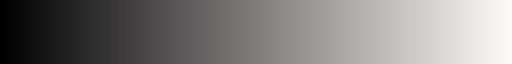

In [13]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'snow'])
cmap

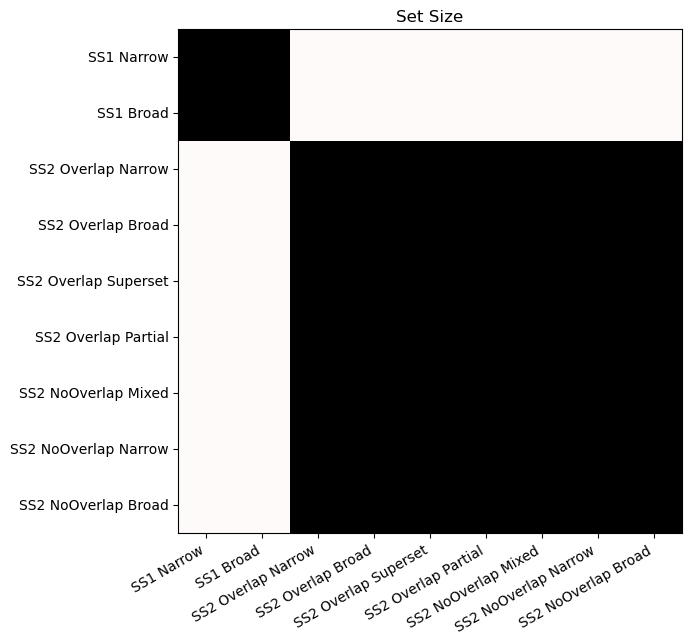

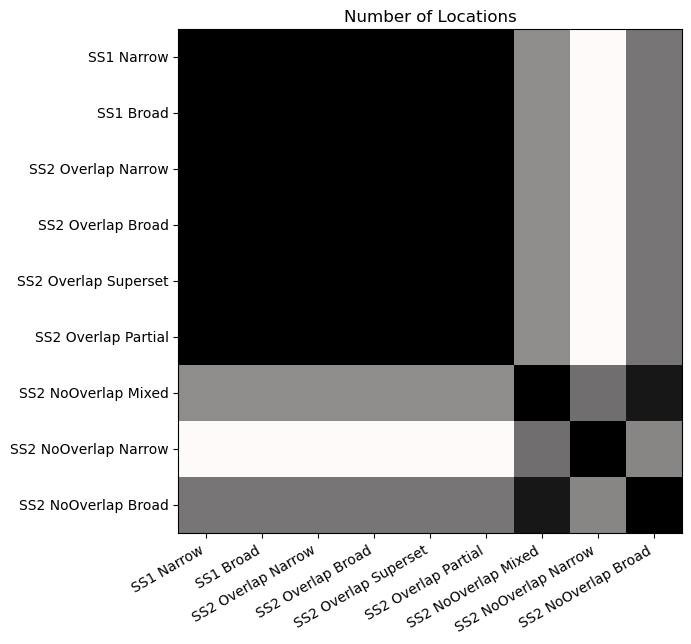

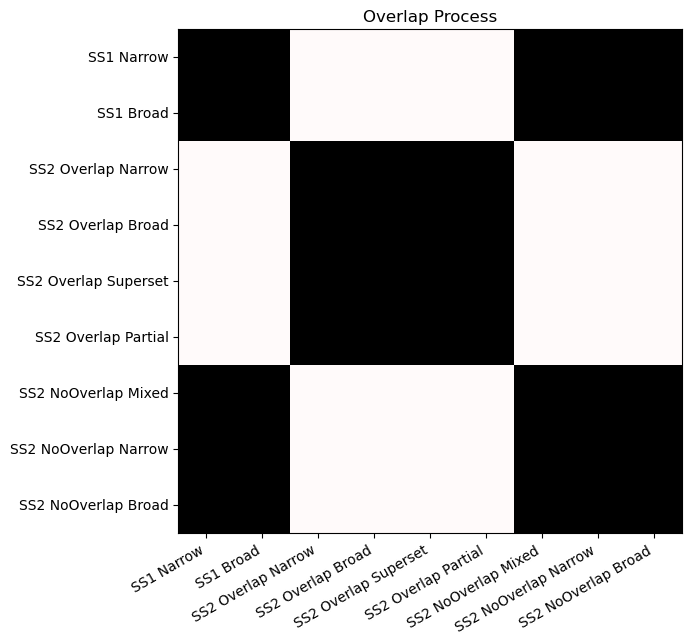

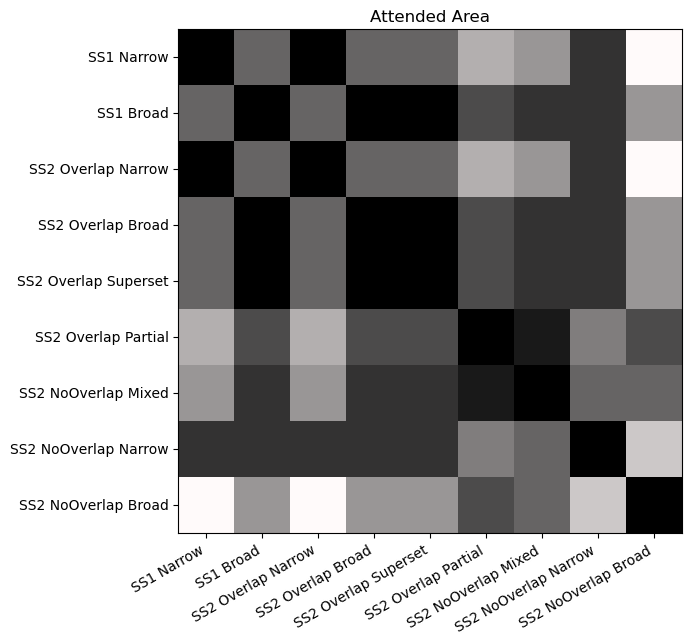

In [16]:
for factor, RDM in RDMs.items():
    plt.figure(facecolor='w', figsize=(7, 7))
    ax = sns.heatmap(RDM, xticklabels=condition_breakdown.keys(), yticklabels=condition_breakdown.keys(), cmap=cmap, square=True, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha='right')
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    plt.title(factor)
    plt.tight_layout()
    plt.savefig(f'RawFigures/theoreticalRDMs/{factor}.svg', dpi=300)
    plt.show()
    plt.close()

In [17]:
# get upper triangle indices
ridx, cidx = np.triu_indices(len(condition_breakdown), k=1)

RDM_df = pd.DataFrame()
for factor, RDM in RDMs.items():
    RDM_df[factor] = RDM[ridx, cidx]
# this isn't the best practice because it's the intercept, not the total, but it makes renaming the columns easier in a results df
RDM_df['Total'] = 1  
RDM_df.head()

,Set Size,Number of Locations,Overlap Process,Attended Area,Total
0,0.0,0.0,0.0,2.0,1
1,1.0,0.0,1.0,0.0,1
2,1.0,0.0,1.0,2.0,1
3,1.0,0.0,1.0,2.0,1
4,1.0,0.0,1.0,3.5,1


## Get the data for each subject and condition

In [18]:
xdata_dict = {}
alpha_dict = {}
behavior_dict = {}

for isub in range(exp.nsub):
    xdata,_ = exp.load_eeg(isub)
    xdata = np.squeeze(xdata[:,:,np.where(times_bool)]) # cut out pre-baseline & test timepoints
    
    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()
    
    behavior = pd.read_csv(exp.behavior_files[isub])
    behavior = clean_behavior(behavior, noArt_idx, isub)    
    assert len(behavior)==xdata.shape[0]
    
    # drop interruption trials for subs 4,5
    no_interruption_trials = (behavior.port_codes < 240).values
    behavior = behavior[no_interruption_trials].reset_index(drop=True)
    xdata = xdata[no_interruption_trials, :, :]
    
    # match nDots across loads
    behavior = behavior.query('total_nDots >= 24')
    xdata = xdata[behavior.index.values, :, :]
    behavior = behavior.reset_index(drop=True)
    
    
    xdata_dict[isub] = xdata
    behavior_dict[isub] = behavior

## Build subjects RDMs for each pair of conditions, at each time bin (50ms)

In [19]:
def _mean_by_condition(X, conds):
    """
    computes the average of each condition in X, ordered by conds
    """
    avs = np.zeros((len(np.unique(conds)), *X.shape[1:]))
    for cond in sorted(np.unique(conds)):
        X_cond = X[conds == cond]
        avs[cond] = X_cond.mean(axis=0)
    return avs


def _means_and_prec(X, conds):
    cond_means = _mean_by_condition(X, conds)
    cond_means_for_each_trial = cond_means[conds]
    _X = X - cond_means_for_each_trial

    return cond_means, LedoitWolf(assume_centered=True).fit(_X).precision_


def _crossnobis_single(X_train, conds_train, X_test, conds_test):
    """
    Uses condition means from both train and test, but only uses the training
    examples to compute the noise covariance/precision matrix. You may have another
    preference, but I did it this way to avoid train-test leakage.
    """
    means_train, noise_train = _means_and_prec(X_train, conds_train)
    means_test = _mean_by_condition(X_test, conds_test)
    rdm = _calc_rdm_crossnobis_single(means_train, means_test, noise_train)
    return squareform(rdm)


def _crossnobis_train_test_across_time(Xdata, y, train, test, cond_order):
    # assumes Xdata is n_trials x n_features x n_times

    X_train, y_train = Xdata[train], y[train]
    X_test, y_test = Xdata[test], y[test]

    rdms = [_crossnobis_single(X_train[..., t], y_train, X_test[..., t], y_test) for t in range(Xdata.shape[-1])]

    return np.stack(rdms, axis=2)[np.ix_(cond_order, cond_order)]  # reorder to match the order of conditions


def crossnobis(Xdata, trial_labels, cond_order, n_jobs=6, n_splits=10000, test_size=0.5):
    enc = LabelEncoder()  # converts condition labels to integer codes
    conds = enc.fit_transform(trial_labels)
    cond_order = enc.transform(cond_order)  # how to resort the final RDMs

    cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)

    parallel, p_func, _ = parallel_func(_crossnobis_train_test_across_time, n_jobs)
    rdms = parallel(p_func(Xdata=Xdata, y=conds, train=train_idx, test=test_idx, cond_order=cond_order) for train_idx, test_idx in cv.split(Xdata, conds))

    rdms = np.stack(rdms, axis=0)
    return rdms.mean(0)

In [20]:
t_starts = np.linspace(0, 725, 30).astype(int)
sub_RDMs = defaultdict(lambda : np.zeros((len(condition_breakdown), len(condition_breakdown), len(t_starts))))

for isub in range(exp.nsub):
    sub_file = f'RDMs/sub{isub}_RDMs.npy'
    if (not os.path.exists(sub_file)) or overwrite_RDMs:

        xdata = xdata_dict[isub]
        behavior = setup_hyperplane_conds(behavior_dict[isub], separate_no_overlap=True)

        # average over time bins of 20ms (5 samples)
        xdata_time_binned = np.zeros((xdata.shape[0], xdata.shape[1], len(t_starts)))
        for tidx, t in enumerate(t_starts):
            xdata_time_binned[:,:,tidx] = xdata[:,:,t:t+25].mean(-1)

        sub_RDMs[isub] = crossnobis(Xdata=xdata_time_binned, trial_labels=behavior['hyperplane_conditions'].astype(int).values, cond_order=np.arange(9), n_jobs=8)

        np.save(sub_file, sub_RDMs[isub])
    else:
        sub_RDMs[isub] = np.load(sub_file)

# Partial Rank Regression, Following Kiat et al., 2022

In [21]:
np.random.seed(2023) # so that the values are the same, regardless of whether we overwrite the RDMs

In [22]:
ranked_vals = rankdata(RDM_df, axis=0)
ranked_vals[:, -1] = 1
ranked_vals

array([[11.5,  8. ,  8.5, 21.5,  1. ],
       [29.5,  8. , 26.5,  2.5,  1. ],
       [29.5,  8. , 26.5, 21.5,  1. ],
       [29.5,  8. , 26.5, 21.5,  1. ],
       [29.5,  8. , 26.5, 32.5,  1. ],
       [29.5, 27.5,  8.5, 29. ,  1. ],
       [29.5, 33.5,  8.5,  9.5,  1. ],
       [29.5, 20.5,  8.5, 35.5,  1. ],
       [29.5,  8. , 26.5, 21.5,  1. ],
       [29.5,  8. , 26.5,  2.5,  1. ],
       [29.5,  8. , 26.5,  2.5,  1. ],
       [29.5,  8. , 26.5, 15.5,  1. ],
       [29.5, 27.5,  8.5,  9.5,  1. ],
       [29.5, 33.5,  8.5,  9.5,  1. ],
       [29.5, 20.5,  8.5, 29. ,  1. ],
       [11.5,  8. ,  8.5, 21.5,  1. ],
       [11.5,  8. ,  8.5, 21.5,  1. ],
       [11.5,  8. ,  8.5, 32.5,  1. ],
       [11.5, 27.5, 26.5, 29. ,  1. ],
       [11.5, 33.5, 26.5,  9.5,  1. ],
       [11.5, 20.5, 26.5, 35.5,  1. ],
       [11.5,  8. ,  8.5,  2.5,  1. ],
       [11.5,  8. ,  8.5, 15.5,  1. ],
       [11.5, 27.5, 26.5,  9.5,  1. ],
       [11.5, 33.5, 26.5,  9.5,  1. ],
       [11.5, 20.5, 26.5,

In [23]:
timepoints = t_starts*2 - 250 + 25  # convert to actual timepoints
timepoints

array([-225, -175, -125,  -75,  -25,   25,   75,  125,  175,  225,  275,
        325,  375,  425,  475,  525,  575,  625,  675,  725,  775,  825,
        875,  925,  975, 1025, 1075, 1125, 1175, 1225])

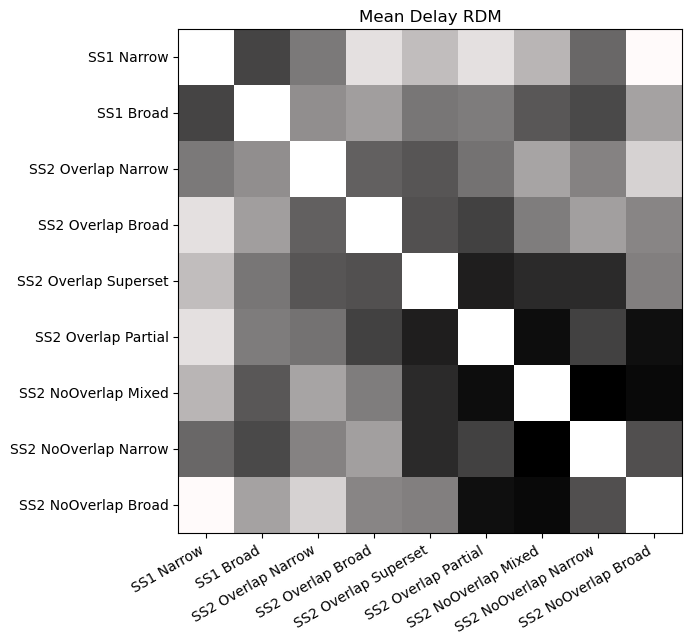

In [24]:
mean_dist_mat = np.zeros((len(condition_breakdown), len(condition_breakdown)))
for isub in range(exp.nsub):
    sub_mean_delay_ranked_dists = rankdata(sub_RDMs[isub][ridx, cidx, :], axis=0)[:,timepoints > 250].mean(1)
    mean_dist_mat[ridx, cidx] += sub_mean_delay_ranked_dists
    
# mirror the matrix
mean_dist_mat += mean_dist_mat.T
mean_dist_mat /= exp.nsub
# set diagonal to nan
np.fill_diagonal(mean_dist_mat, np.nan)

# plot and save mean RDM
plt.figure(facecolor='w', figsize=(7, 7))
ax = sns.heatmap(mean_dist_mat, xticklabels=condition_breakdown.keys(), yticklabels=condition_breakdown.keys(), cmap=cmap, square=True, cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha='right')
plt.title('Mean Delay RDM')
plt.tight_layout()
plt.savefig('RawFigures/mean_delay_ranked_RDM.svg', dpi=300)
for _, spine in ax.spines.items():
        spine.set_visible(True)
plt.show()
plt.close()

In [18]:
partial_r_df = pd.DataFrame()

for isub in range(exp.nsub):
    ranked_dists = rankdata(sub_RDMs[isub][ridx, cidx, :], axis=0) 

    r_scores = defaultdict(lambda : np.zeros((ranked_dists.shape[1])))
    for t in range(ranked_dists.shape[1]):
        curr_dists = ranked_dists[:, t]

        fitted_lm = LinearRegression().fit(ranked_vals, curr_dists)
        full_r2 = fitted_lm.score(ranked_vals, curr_dists)

        # get partial r for each factor
        for col in range(ranked_vals.shape[1]-1): # skip intercept column
            submodel_r2 = LinearRegression().fit(np.delete(ranked_vals, col, axis=1), curr_dists).score(np.delete(ranked_vals, col, axis=1), curr_dists)
            r_scores[col][t] = np.sqrt(full_r2 - submodel_r2) * np.sign(fitted_lm.coef_[col])

        r_scores[ranked_vals.shape[1]][t] = np.sqrt(full_r2)


    # make into a dataframe
    r_df = pd.DataFrame(r_scores)
    r_df.columns = RDM_df.columns
    r_df['sid'] = isub
    r_df['timepoint'] = timepoints
    sub_df = pd.melt(r_df, id_vars=['sid', 'timepoint'], value_vars=r_df.columns[:-2], var_name='factor', value_name='semipartial correlation')

    partial_r_df = pd.concat([partial_r_df, sub_df], axis=0)

partial_r_df = partial_r_df.reset_index(drop=True)

In [ ]:
partial_r_df.to_csv('output/RDMs_partialCorr_timeseries.csv', index=False)  # examined in wilcoxon_bf/RSAcomputeWilcoxonBFs.RMD

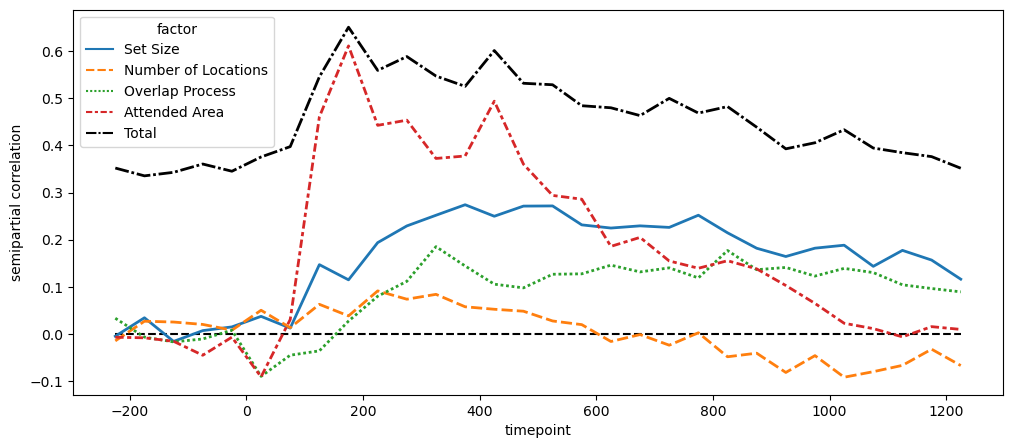

In [19]:
plt.figure(facecolor='white', figsize=(12, 5))
plt.plot(timepoints, np.zeros(len(timepoints)), color='black', linestyle='--')
_ = sns.lineplot(data=partial_r_df, x='timepoint', y='semipartial correlation', hue='factor', errorbar=None, palette=color_palette, style='factor', linewidth=2)

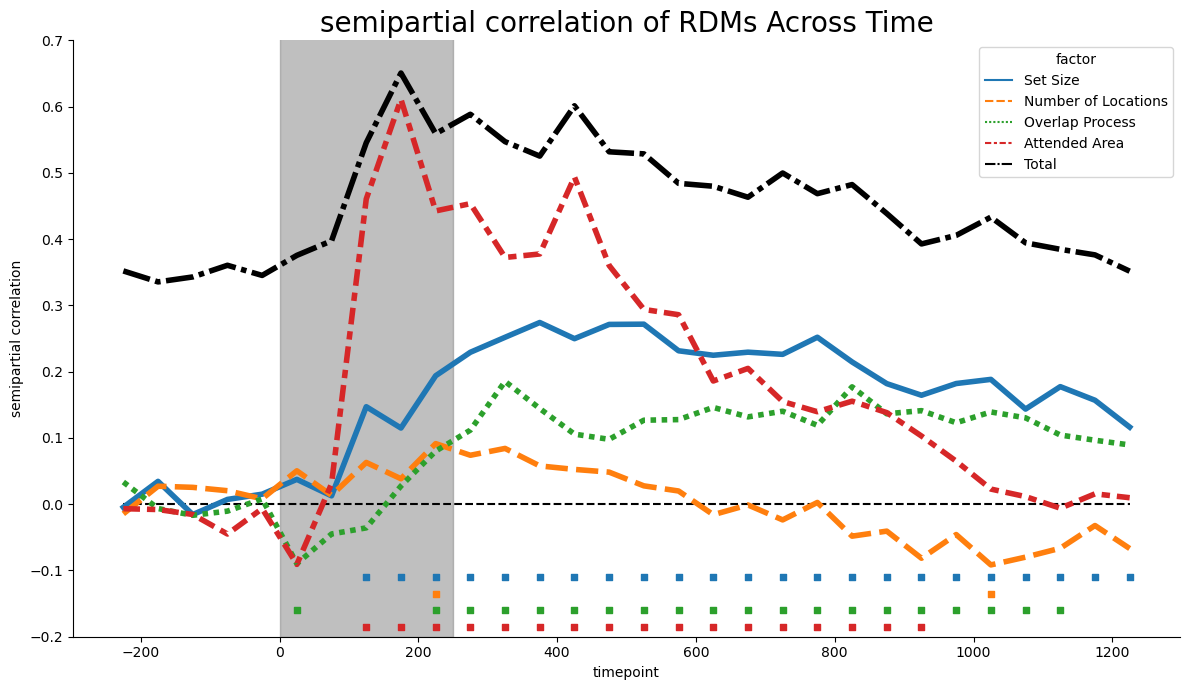

In [20]:
plt.figure(figsize=(12, 7))
plt.fill_between([0, 250], [-.2, -.2], [.72, .72], color='gray', alpha=.5)
plt.plot(timepoints, np.zeros(len(timepoints)), color='black', linestyle='--')
ax = sns.lineplot(data=partial_r_df, x='timepoint', y='semipartial correlation', hue='factor', errorbar=None, linewidth=4, palette=color_palette, style='factor')


for i,factor in enumerate(partial_r_df['factor'].unique()):

    if factor=='Total':
        continue

    p_vals = []
    for t in partial_r_df['timepoint'].unique():
        x = partial_r_df.query(f"timepoint=={t} and factor=='{factor}'")['semipartial correlation'].values
        _,p = wilcoxon(x=x)
        p_vals.append(p)

    _, corrected_p, _, _ = multipletests(p_vals, method='fdr_bh')
    sig05 = corrected_p < .05
    
    plt.scatter(timepoints[sig05], np.ones(sum(sig05))*(-.11-.025*i),
                            marker='s', s=15, color=color_palette[factor], label='p < .05')
    sig_timepoints = timepoints[sig05]
    # print(f'{factor}" Significant timepoints: {sig_timepoints}')

plt.ylim([-.2, .7])
ax.spines[['right', 'top']].set_visible(False)
_ = plt.title('semipartial correlation of RDMs Across Time', fontsize=20)
plt.tight_layout()
plt.savefig('RawFigures/RDMs_partialCorr_timeseries.svg', dpi=300, bbox_inches='tight')


### Examining Bayes Factors (see /wilcoxon_bf folder)

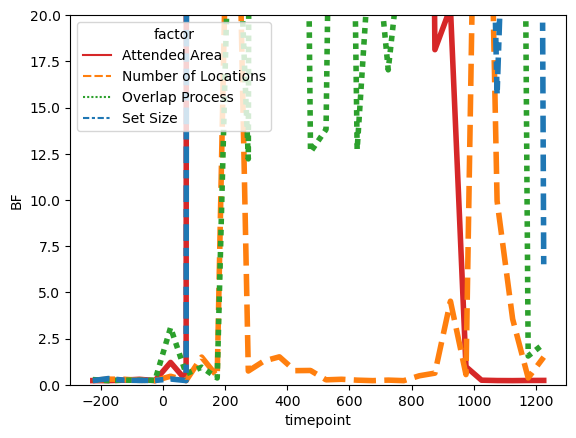

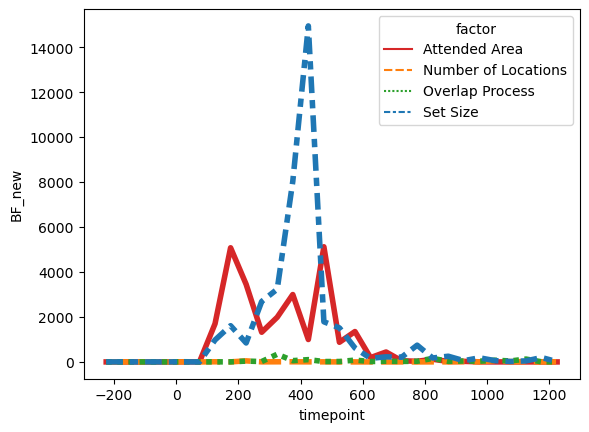

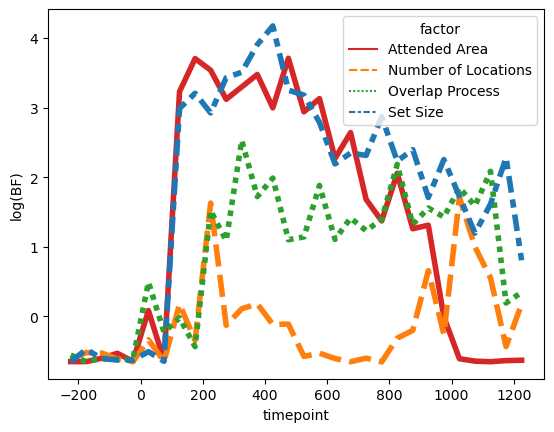

In [34]:
BFs_by_timepoint = pd.read_csv('wilcoxon_bf/RSA_byTimepoint_BFs.csv')

null_bfs = BFs_by_timepoint['BF'] < 1
BFs_by_timepoint['BF_new'] = BFs_by_timepoint['BF'].values
BFs_by_timepoint.loc[null_bfs, 'BF_new'] = 1/ BFs_by_timepoint.loc[null_bfs, 'BF_new'] # flip to be large

BFs_by_timepoint['log(BF)'] = np.log10(BFs_by_timepoint['BF_new'])
BFs_by_timepoint.loc[null_bfs, 'log(BF)'] = -BFs_by_timepoint.loc[null_bfs, 'log(BF)'] # sign flip for direction

BFs_by_timepoint.loc[null_bfs, 'BF_new'] = -BFs_by_timepoint.loc[null_bfs, 'BF_new'] # sign flip for direction

ax = sns.lineplot(data=BFs_by_timepoint, x='timepoint', y='BF', hue='factor', errorbar=None, linewidth=4, palette=color_palette, style='factor')
plt.ylim([0, 20])
plt.show()
plt.close()

ax = sns.lineplot(data=BFs_by_timepoint, x='timepoint', y='BF_new', hue='factor', errorbar=None, linewidth=4, palette=color_palette, style='factor')
plt.show()
plt.close()

ax = sns.lineplot(data=BFs_by_timepoint, x='timepoint', y='log(BF)', hue='factor', errorbar=None, linewidth=4, palette=color_palette, style='factor')
plt.show()
plt.close()

## Average across the delay period, to increase power

In [21]:
def plot_and_test_delay_corrs(partial_r_df, delay_start=250, delay_end=1150, figname=None, fac_order=['Set Size', 'Overlap Process', 'Attended Area', 'Number of Locations'], sig_marker_y=.3, excluded_bad_eyes=False):
    delay_summary_df = partial_r_df.query(f'timepoint > {delay_start} and timepoint <= {delay_end}').groupby(['sid', 'factor']).mean().reset_index()
    delay_summary_df = delay_summary_df[~(delay_summary_df.factor=='Total')] # ignore total
    delay_summary_df.to_csv(f'output/RDMs_partialCorr_delay{delay_start}-{delay_end}_excludeBadEyes-{excluded_bad_eyes}.csv', index=False)
    plt.figure(facecolor='white', figsize=(8, 4))
    plt.hlines(0, xmin=-.5, xmax=3.5, color='black', linestyle='--')
    ax = sns.barplot(data=delay_summary_df, x='factor', y='semipartial correlation', errorbar=('ci', 68), palette=color_palette, order=fac_order)
    for i,factor in enumerate(fac_order):
        
        x = delay_summary_df.query(f'factor=="{factor}"')['semipartial correlation'].values
        w,p = wilcoxon(x=x)
        print(factor, np.mean(x), w, p)
        if p < .05:
            plt.scatter(i, sig_marker_y, marker='*', s=50, color=color_palette[factor], label='p < .05')

    ax.spines[['right', 'top']].set_visible(False)
    _ = plt.title('semipartial correlation of RDMs During Delay Period', fontsize=20)
    plt.tight_layout()
    if figname is not None:
        plt.savefig(f'RawFigures/{figname}', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

Set Size 0.2202292241603081 7.0 4.5299530029296875e-06
Overlap Process 0.13265832583890055 28.0 0.00034928321838378906
Attended Area 0.21179229113010004 1.0 4.76837158203125e-07
Number of Locations -0.007118257529673236 122.0 0.6433901786804199


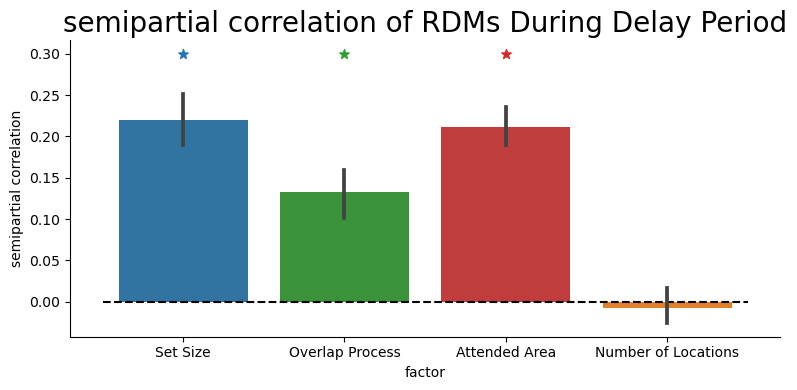

In [22]:
plot_and_test_delay_corrs(partial_r_df, figname='RDMs_partialCorr_barplots.svg')

## Split delay period in half

Set Size 0.24818936178095138 1.0 4.76837158203125e-07
Overlap Process 0.13079398384882382 29.0 0.00040793418884277344
Attended Area 0.33646821082134915 0.0 2.384185791015625e-07
Number of Locations 0.038580118195615 85.0 0.11142587661743164


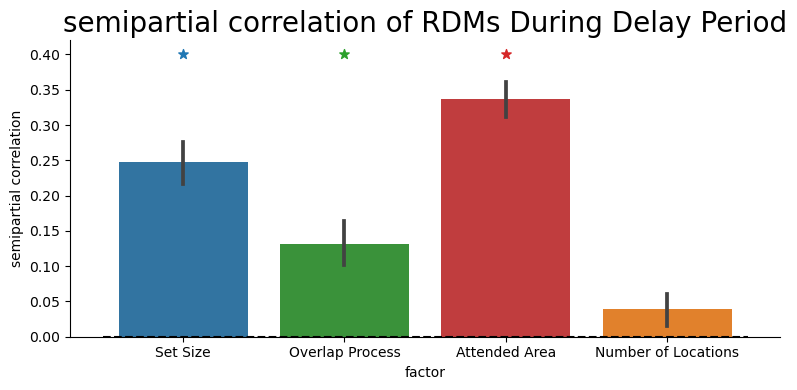

In [24]:
plot_and_test_delay_corrs(partial_r_df, delay_start=250, delay_end=700, figname='RDMs_partialCorr_barplots_firstHalf.svg', sig_marker_y=.4)

Set Size 0.1922690865396649 24.0 0.00018143653869628906
Overlap Process 0.13452266782897732 36.0 0.0011184215545654297
Attended Area 0.08711637143885087 55.0 0.010109186172485352
Number of Locations -0.05281663325496146 73.0 0.04844093322753906


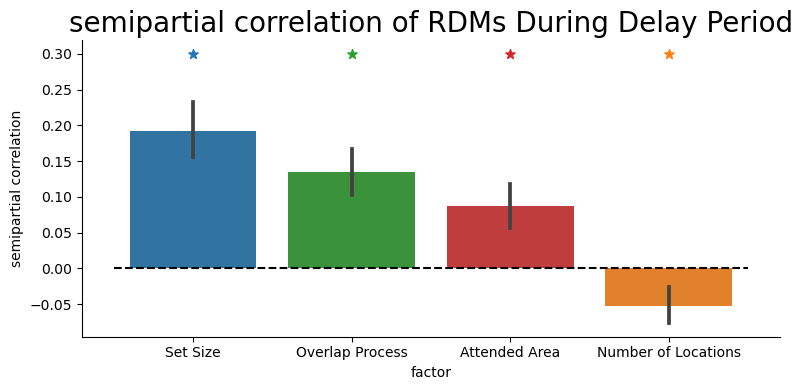

In [25]:
plot_and_test_delay_corrs(partial_r_df, delay_start=700, figname='RDMs_partialCorr_barplots_lastHalf.svg')

# Remove participants with informative eye movements

In [26]:
bad_eyes = pd.read_csv('informative_eye_subs.csv', index_col=0).index.values
partial_r_df = partial_r_df[~partial_r_df.sid.isin(bad_eyes)]

Set Size 0.20747083859627086 5.0 3.814697265625e-05
Overlap Process 0.09985361997227561 28.0 0.005329132080078125
Attended Area 0.2240167518080931 1.0 7.62939453125e-06
Number of Locations 0.00025742405294977637 95.0 1.0


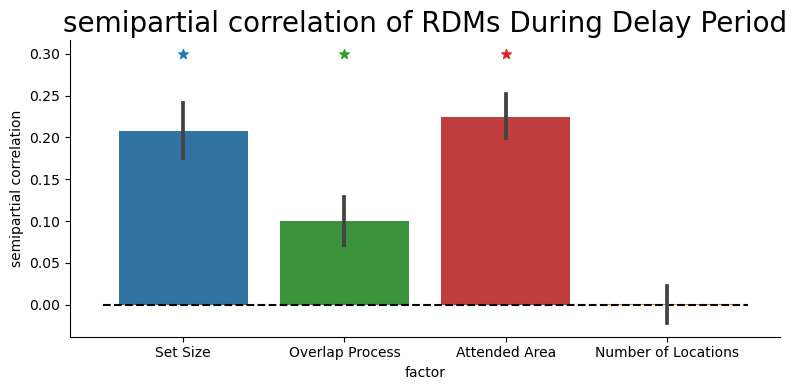

In [27]:
plot_and_test_delay_corrs(partial_r_df, excluded_bad_eyes=True)

Set Size 0.24708444391141485 1.0 7.62939453125e-06
Overlap Process 0.09959130492668633 28.0 0.005329132080078125
Attended Area 0.3502881144235684 0.0 3.814697265625e-06
Number of Locations 0.03891714326301893 58.0 0.14468765258789062


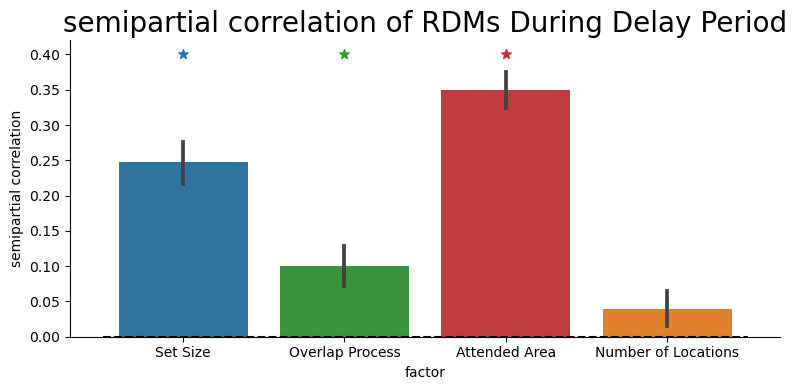

In [28]:
plot_and_test_delay_corrs(partial_r_df, delay_start=250, delay_end=700, sig_marker_y=.4, excluded_bad_eyes=True)

Set Size 0.16785723328112687 20.0 0.00141143798828125
Overlap Process 0.1001159350178649 36.0 0.015972137451171875
Attended Area 0.09774538919261785 35.0 0.014068603515625
Number of Locations -0.03840229515711938 58.0 0.14468765258789062


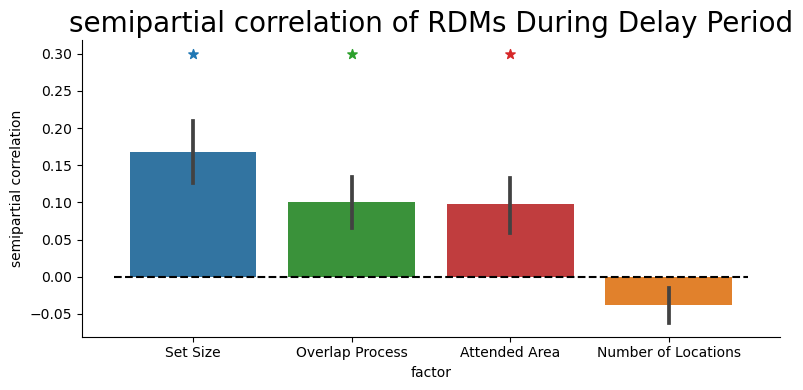

In [29]:
plot_and_test_delay_corrs(partial_r_df, delay_start=700, excluded_bad_eyes=True)